Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.



C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.3615 - loss: 6.6306 - val_accuracy: 0.4078 - val_loss: 1.0036
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.4467 - loss: 0.9962 - val_accuracy: 0.5437 - val_loss: 0.9382
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6754 - loss: 0.9169 - val_accuracy: 0.6311 - val_loss: 0.7913
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6509 - loss: 0.7064 - val_accuracy: 0.7476 - val_loss: 0.7384
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8110 - loss: 0.4714 - val_accuracy: 0.7282 - val_loss: 0.6308
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7676 - loss: 0.5237 - val_accuracy: 0.6893 - val_loss: 0.7263
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8310 - loss: 0.4705 - val_accuracy: 0.6893 - val_loss: 0.7805
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8722 - loss: 0.3375 - val_accuracy: 0.6699 - val_loss:

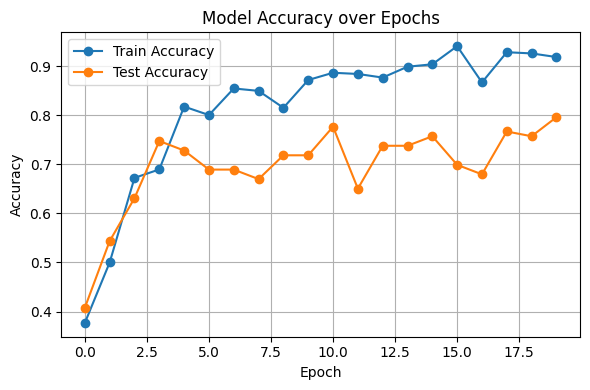

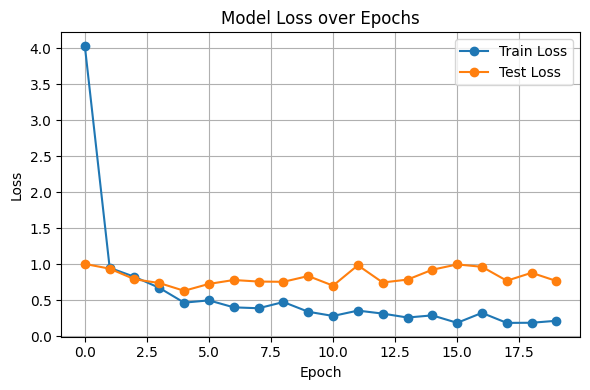

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import os
import random

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 🔹 Hyperparameters
batch_size = 16
dropout_rate = 0.3
learning_rate = 0.001
image_size = (224, 224, 3)

train_dir = 'D:/Lung_cancer/train'
val_dir = "D:/Lung_cancer/LC25000_sampled"
test_dir = 'D:/Lung_cancer/test'

# ---- Data Preprocessing ----
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed   
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ✅ Custom Multi-Head Attention Layer
class MultiHeadAttentionLayer(layers.Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super(MultiHeadAttentionLayer, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        inputs = tf.expand_dims(inputs, axis=1)
        attn_output = self.attention(inputs, inputs)
        return tf.squeeze(attn_output, axis=1)

# ---- Define Model ----
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size)
base_model.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = MultiHeadAttentionLayer()(x)
x = layers.Dropout(dropout_rate)(x)
output = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# ---- Compile Model ----
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ---- Train Model ----
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    batch_size=batch_size,
    verbose=1
)

# ---- Evaluate Model ----
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

import numpy as np
import pickle
# ---- Save the training history as a pickle file (.pkl) ----
history_file = 'resnet_multiheadattention_cv(new).pkl'

with open(history_file, 'wb') as f:
    pickle.dump(history.history, f)

print("Model training complete and history")

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.76      0.62      0.68       500
               Nor       0.97      0.91      0.94       500
Squamous_carcinoma       0.71      0.88      0.79       500

          accuracy                           0.80      1500
         macro avg       0.81      0.80      0.80      1500
      weighted avg       0.81      0.80      0.80      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.81      0.74      0.77        39
               Nor       0.87      0.84      0.85        31
Squamous_carcinoma       0.73      0.82      0.77        33

          accuracy                           0.80       103
         macro avg       0.80      0.80      0.80       103
      weighted avg       0.80      0.80      0.80       103

Validation Accuracy: 0.80266666

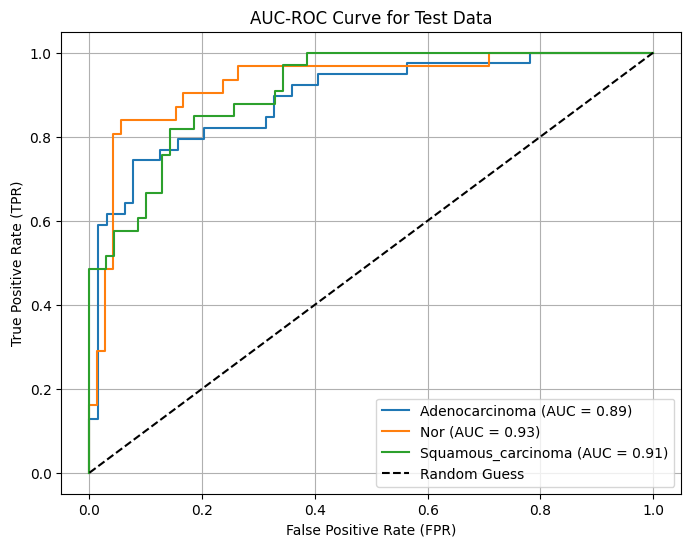


Macro-Averaged Test AUC: 0.91
94/94 ━━━━━━━━━━━━━━━━━━━━ 93s 993ms/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.87
Nor - AUC: 0.99
Squamous_carcinoma - AUC: 0.92


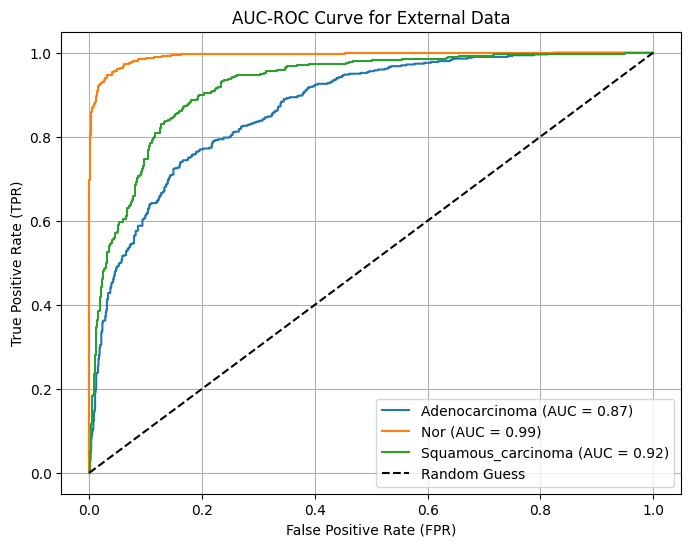


Macro-Averaged External AUC: 0.93


In [4]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged External AUC: {macro_roc_auc:.2f}")

Class Labels: ['Adenocarcinoma', 'Nor', 'Squamous_carcinoma']
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 900ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


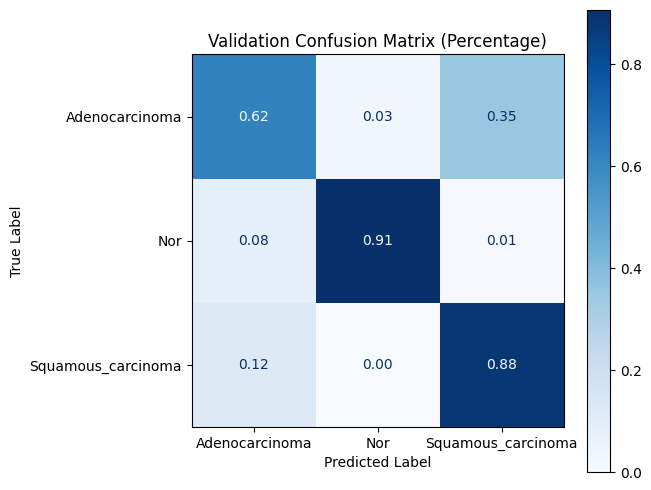

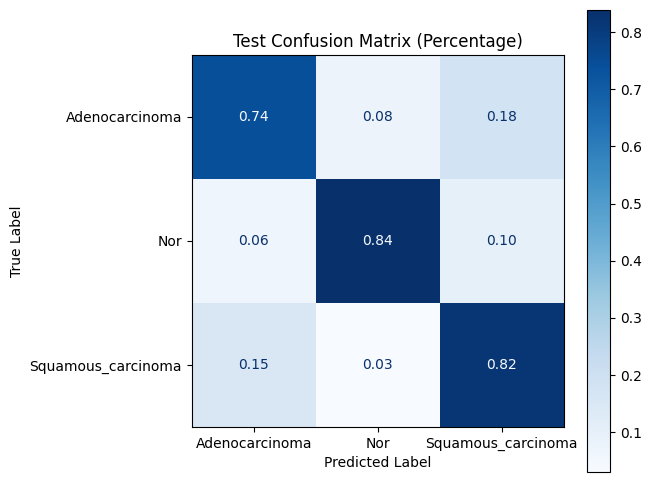

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Get Class Labels ---
class_names = list(val_generator.class_indices.keys())
print("Class Labels:", class_names)

# --- Predict on Validation and Test Sets ---
val_preds = model.predict(val_generator)
test_preds = model.predict(test_generator)

# --- Convert probabilities to class labels ---
val_pred_classes = np.argmax(val_preds, axis=1)
test_pred_classes = np.argmax(test_preds, axis=1)

# --- Get true labels ---
val_true_classes = val_generator.classes
test_true_classes = test_generator.classes

# --- Confusion Matrices ---
val_cm = confusion_matrix(val_true_classes, val_pred_classes)
test_cm = confusion_matrix(test_true_classes, test_pred_classes)

# --- Normalize Confusion Matrices to Percentages ---
val_cm_percent = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis] 
test_cm_percent = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis] 

# --- Plot Function ---
def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax, colorbar=True)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Plot Confusion Matrices ---
plot_confusion_matrix(val_cm_percent, class_names, "Validation Confusion Matrix (Percentage)")
plot_confusion_matrix(test_cm_percent, class_names, "Test Confusion Matrix (Percentage)")
